# Машинное обучение, ШАД
## Домашнее задание 4: Регуляризация в линейных моделях


----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import special
  # допиши необходимые импорты

sns.set_theme(palette='Set2', font_scale=1.2)

### Ссылки на использование ИИ

Если при решении задач использовался ИИ, укажите здесь ссылки.

**Задача 1**
1. ...
2. ...

**Задача 2**
1. ...
2. ...

**Задача 3**
1. ...
2. ...

---
### Задача 1.

Исследуем Elastic-регрессию. Визуализируйте множество, которое ограничивает коэффициенты в Elastic-регрессии. Выпишите формулы шага для градиентного спуска и стохастического градиентного спуска.

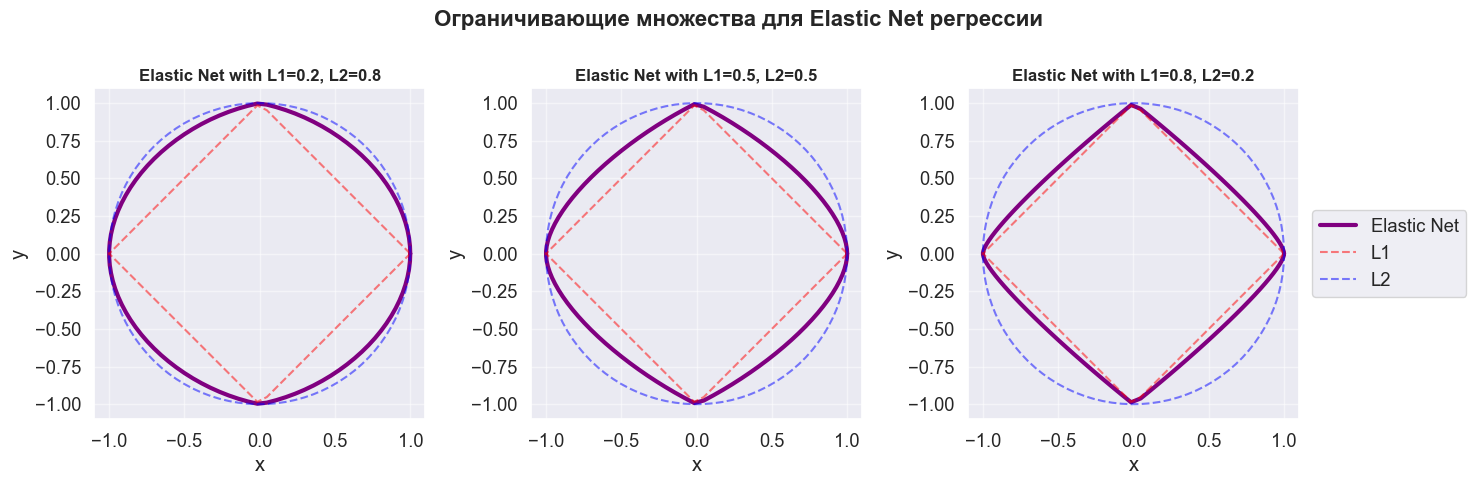

In [518]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ratios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
    
for i, ((l1_ratio, l2_ratio), ax) in enumerate(zip(ratios, axes.flat)):
    t = np.linspace(0, 2*np.pi, 100)
    all_x = np.cos(t)
    
    ellipse_y = np.sin(t)
    diamond_y = []
    for x, y in zip(all_x, ellipse_y):
        if (x >= 0) and (y > 0):
            diamond_y.append(1 - x)
        elif (x < 0) and (y >= 0):
            diamond_y.append(x + 1)
        elif (x <= 0) and (y < 0):
            diamond_y.append(-x - 1)
        elif (x > 0) and (y <= 0):
            diamond_y.append(x - 1)
    diamond_y = np.array(diamond_y)
    
    elastic_y = diamond_y * l1_ratio + ellipse_y * l2_ratio
    scale = 1.0 / (l1_ratio + l2_ratio) if (l1_ratio + l2_ratio) > 0 else 1.0
    elastic_y *= scale

    ax.plot(all_x, elastic_y, 'purple', linewidth=3, label='Elastic Net')

    ax.plot(all_x, diamond_y, linestyle='--', color='red', alpha=0.5, label='L1')
    ax.plot(all_x, ellipse_y, linestyle='--', color='blue', alpha=0.5, label = 'L2')

    ax.set_aspect('equal')
    ax.grid(True, alpha=0.5)
    ax.set_title(f'Elastic Net with L1={l1_ratio}, L2={l2_ratio}', fontsize=12, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if (i == 2):
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

plt.suptitle('Ограничивающие множества для Elastic Net регрессии', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Мы оптимизирует следующую функцию
$$
f(\theta) = ||Y - X\theta||_{2}^{2} + \lambda_{1}||\theta||_{1} + \lambda_{2}||\theta||_{2}^{2} 
$$

Запишем градиент
$$
\nabla f(\theta) = 2X^{T}(X\theta - Y) +  \lambda_{1}\overline{\operatorname{sign}} \theta +  2\lambda_{2}\theta
$$

Тогда запишем шаг градиентного спуска
$$
\theta_{t+1} = \theta_{t} - \eta\left(2X^{T}(X\theta_{t} - Y) +  \lambda_{1}\overline{\operatorname{sign}} \theta_{t} +  2\lambda_{2}\theta_{t}\right)
$$
$$
\theta_{t+1} = \theta_{t} - \eta\left(2\sum\limits_{i=1}^{n}\left[x_{i}(x_{i}^{T}\theta_{t} - Y_{i})\right] +  \lambda_{1}\overline{\operatorname{sign}} \theta_{t} +  2\lambda_{2}\theta_{t}\right)
$$

Запишем шаг стохастического градиентного спуска
$$
\theta_{t+1} = \theta_{t} - \eta\left(\frac{2n}{k}\sum\limits_{j=1}^{k}\left[x_{i_{j}}(x_{i_{j}}^{T}\theta_{t} - Y_{i_{j}})\right] +  \lambda_{1}\overline{\operatorname{sign}} \theta_{t} +  2\lambda_{2}\theta_{t}\right)
$$

---
### Задача 2.

Рассмотрим модель логистической регрессии. Признаки объекта представимы в виде $d$-мерного вектора $x \in \mathbb{R}^d$, класс имеет бернулиевское распределение $Y \sim Bern(\mu_\theta(x))$. Мы делаем следующее предположение о зависимости параметра вероятности от признаков:
$${\mu_\theta(x) = \sigma(x^T\theta)= \cfrac{1}{1 + e^{-x^T\theta}}}.$$

Зададим регуляризацию через минимизацию следующего функционала:

$$F(\theta) = -\sum_{i=1}^n \left[Y_i \log{\sigma(\theta^T x_i)} + (1 - Y_i) \log{\left(1 - \sigma(\theta^T x_i)\right)}\right] + \lambda\theta^T \theta.$$

**1.** Выведите формулы градиентного спуска (GD) и стохастического градиентного спуска (SGD).

**2.** Покажите, что $F(\theta)$ &mdash; выпуклая функция по $\theta$ и, как следствие, имеет единственный экстремум, являющийся глобальным максимумом. *Указание*. Посчитайте гессиан (матрицу вторых производных) и покажите, что она положительно определена.

**3.** Опишите, как может вести себя решение при отсутствии регуляризации, то есть при $\lambda = 0$

**1.** Запишем градиент минимизируемого функционала
$$
\nabla F(\theta) = -\sum\limits_{i=1}^{n}[Y_{i}(1-\sigma(\theta^{T}x_{i}))x_{i} - (1-Y_{i})\sigma(\theta^{T}x_{i})x_{i}] + 2\lambda\theta
$$
$$
\nabla F(\theta) = \sum\limits_{i=1}^{n}[(\sigma(\theta^{T}x_{i}) - Y_{i})x_{i}] + 2\lambda\theta
$$
Тогда шаг градиентного спуска
$$
\theta_{t+1} = \theta_{t} - \eta \, \left(\sum\limits_{i=1}^{n}[(\sigma(\theta_{t}^{T}x_{i}) - Y_{i})x_{i}] + 2\lambda\theta_{t}\right)
$$
А шаг стохастического градиентного спуска
$$
\theta_{t+1} = \theta_{t} - \eta \, \left(\frac{n}{k}\sum\limits_{j=1}^{k}[(\sigma(\theta_{t}^{T}x_{i_{j}}) - Y_{i_{j}})x_{i_{j}}] + 2\lambda\theta_{t}\right)
$$

**2.** Посчитаем гессиан
$$
H_{F} = \sum\limits_{i=1}^{n}\sigma(\theta^{T}x_{i})\sigma(-\theta^{T}x_{i})x_{i}x_{i}^{T} + \lambda I,
$$
где $x_{i}x_{i}^{T}$ - матрица, где $(x_{i}x_{i}^{T})_{kl} = (x_{i})_{k}\cdot(x_{i})_{l}.$ Заметим, что
$$
v^{T}(x_{i}x_{i}^{T})v = (x_{i}^{T}v)^2
$$
Следовательно, матрицы $x_{i}x_{i}^{T}$ положительно определены, при этом $\lambda \geq 0,$ т.е. $\lambda I$ положительно определена, и $\sigma(\theta^{T}x_{i})\sigma(-\theta^{T}x_{i}) \geq 0,$ поэтому гессиан $H_{F}$ тоже положительно определён. Значит функция $F(\theta)$ выпуклая.

**3.** Как обычная логистическая регрессия без регуляризации, т.к. оценка $\hat\theta$ функционала кросс-энтропии $F$ совпадает с оценкой максимального правдоподобия для логистической регрессии.  

---
### Задача 3.


**Введение**

Рассмотрим обезличенные [данные](https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification) о профилях пользователей ВК. Здесь собрана информация почти о 6 тыс. аккаунтах. Часть из них принадлежит реальным людям, а часть &mdash; боты. В этой задаче вы увидите, как регуляризация влияет на интерпретацию коэффициентов модели логистической регрессии.


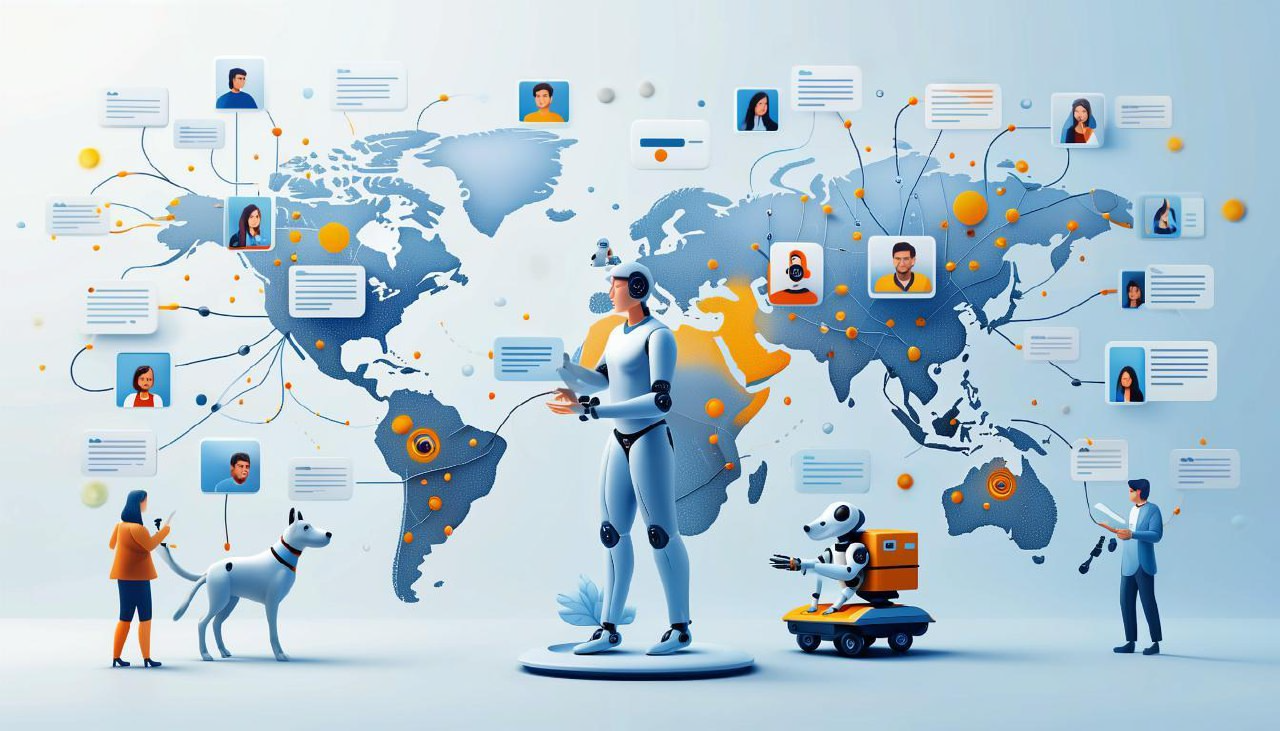

**Описание датасета**

Данные содержат 60 столбцов. Столбец `target` &mdash; метка целевого класса (бот/пользователь). Признаки можно условно разбить на несколько групп:

1. Числовые признаки:
    -   Метрики активности (среднее кол-во постов за неделю)
    -   Количество друзей/подписчиков
2. Категориальные признаки:
    -   Атрибуты профиля (установлен ли аватар, указан ли номер телефона)
    -   Город
    -   Настройки приватности (закрытый/открытый профиль)
    -   Различные бинарные флаги (можно ли писать в личные сообщения)

**1.** **Загрузка и подготовка данных**

Загрузите датасет, выведите его размер и описание числовых фичей при помощи метода `describe`. Отличается ли масштаб у числовых признаков?

In [10]:
data = pd.read_csv("./datasets/bots_vs_users.csv")

real_features = ['posts_count', 'avg_likes', 'subscribers_count', 'avg_keywords', 'avg_text_length', 'links_ratio', 'attachments_ratio', 'avg_comments',
       'reposts_ratio', 'ads_ratio', 'avg_views', 'posting_frequency_days', 'phone_numbers_ratio', 'avg_text_uniqueness']

cat_features = ['has_domain', 'has_birth_date', 'has_photo', 'can_post_on_wall', 'can_send_message', 'has_website', 'gender', 'has_short_name',
                'has_first_name', 'has_last_name', 'access_to_closed_profile', 'is_profile_closed', 'has_nickname', 'has_maiden_name', 
                'has_mobile', 'all_posts_visible', 'audio_available', 'has_interests', 'has_books', 'has_tv', 'has_quotes', 'has_about', 'has_games',
                'has_movies', 'has_activities', 'has_music', 'can_add_as_friend', 'can_invite_to_group', 'is_blacklisted',
                'has_career', 'has_military_service', 'has_hometown', 'marital_status', 'has_universities', 'has_schools', 'has_relatives', 'is_verified',
                'is_confirmed', 'has_status', 'city', 'has_occupation', 'occupation_type_university', 'has_personal_data']

target_feature = ['target']

print(f'Shape of dataset: {data.shape}')
data[real_features].describe()

Shape of dataset: (5874, 60)


,posts_count,avg_likes,avg_keywords,avg_text_length,links_ratio,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness
count,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000,1391.000000
mean,18.629044,19.552487,7.730661,544.752035,0.156463,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
std,4.231994,41.954881,11.278711,746.728130,0.202730,0.170084,2.461709,0.397830,0.033136,1617.635460,154.970296,0.009545,0.229815
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.400000,1.100000,86.600000,0.000000,0.850000,0.000000,0.050000,0.000000,9.125000,1.980000,0.000000,0.580000
50%,20.000000,7.600000,3.400000,267.800000,0.100000,0.950000,0.000000,0.300000,0.000000,268.950000,30.950000,0.000000,0.710000
75%,20.000000,26.075000,7.850000,616.850000,0.200000,1.000000,0.200000,0.900000,0.000000,746.050000,89.480000,0.000000,0.830000
max,20.000000,894.900000,61.600000,5841.250000,1.000000,1.000000,64.050000,1.000000,0.950000,41415.700000,2866.590000,0.300000,1.000000


**Ответ:** Да, отличается

Подсчитайте количество уникальных значений в столбце `city` и выведите 5 наиболее частых городов.

In [255]:
print(f"With Unknown: {len(data['city'].unique())}, without Unknown: {len(data['city'].unique())-1}")

data['city'].value_counts()[:6]

With Unknown: 362, without Unknown: 361


city
Unknown             2780
Saint Petersburg    1549
Kostomuksha          405
Moscow               335
Petrozavodsk         103
Nizhny Novgorod       18
Name: count, dtype: int64

**Вывод:** Много пропусков, при этом большая часть людей, для которых известно, сконцентрированна в паре крупных городов, в остальных городах очень мало людей, т.е. сильный дисбаланс классов.

Само название города, который указан в профиле, нам не особо важно. **Замените** этот признак на простой бинарный флаг: указан/отсутствует.

In [11]:
data['city'] = (~data['city'].isin(['Unknown'])).astype(int)

Выделите целевую переменную и матрицу признаков, убрав из неё лишние столбцы:

In [12]:
y = data[target_feature]
x = data.drop(target_feature, axis=1)
pd.concat([y, x], axis=1)

,target,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,Unknown,Unknown,Unknown,Unknown
1,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,Unknown,Unknown,Unknown,Unknown
2,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,Unknown,Unknown,Unknown,Unknown
3,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,Unknown,Unknown,Unknown,Unknown
4,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,0,1.0,1.0,1.0,0.0,0.0,Unknown,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,1.0,Unknown
5870,0,1.0,Unknown,1.0,0.0,0.0,Unknown,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,0.0,Unknown
5871,0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,0.0,Unknown
5872,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,1.0,0.0,1.0,Unknown


Посчитайте количество нулей и единиц таргете. Лучше всего представить ответ в виде графика с двумя столбцами, высота которых соответствует количеству объектов класса (см. например, [`sns.countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html)). Есть ли дисбаланс между классами?

<Axes: xlabel='target', ylabel='count'>

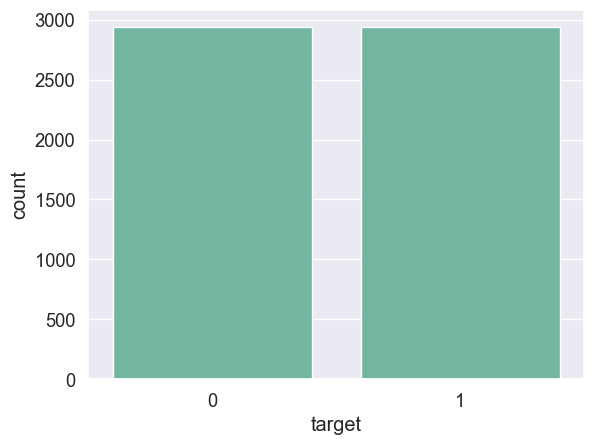

In [300]:
sns.countplot(data = y, x='target')

**Ответ:** Нет, дисбаланса в классах нет.

Разделите данные на трейн и тест. Аналогичным образом выведите распределение таргета по классам для обеих выборок. Соотношение классов в обучающей и тестовой частях должно быть одинаковым.

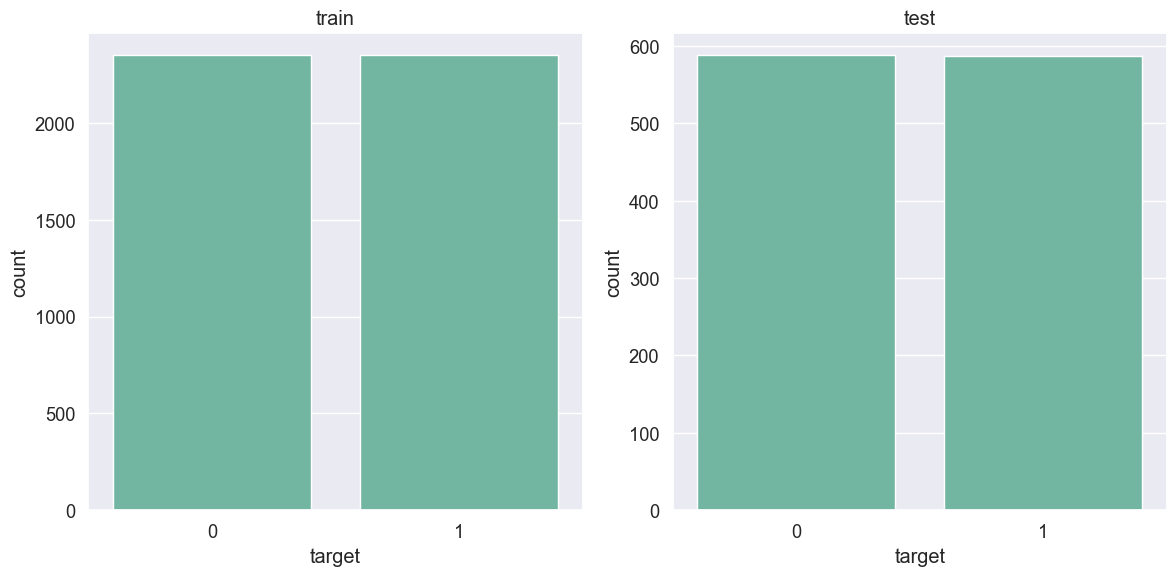

In [326]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

fig, ax = plt.subplots(1, 2, figsize = (12, 6))


sns.countplot(data = y_train, x='target', ax = ax[0])
ax[0].set_title('train')

sns.countplot(data = y_test, x='target', ax = ax[1])
ax[1].set_title('test')

plt.tight_layout()
plt.show()

**Ответ:** Соотношение классов в обучающей и тестовой части одинаковое.

Стандартизируйте **обучающую выборку**

In [13]:
x_train['subscribers_count'] = x_train['subscribers_count'].replace('Unknown', np.nan)


In [14]:
scaler = StandardScaler().set_output(transform="pandas")
scaled_real_x_train = scaler.fit_transform(x_train[real_features])

x_train = pd.concat([x_train[cat_features], scaled_real_x_train], axis=1)

Согласно описанию на странице датасета, в данных присутствуют пропуски. Причём в числовых признаках они отмечены значением `NaN`, а в категориальных &mdash; строкой `"Unknown"`. Используя [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html), заполните **числовые пропуски** средними значениями. Для каждого числового признака с пропусками создайте дополнительный признак-флаг, указывающий на наличие или отсутствие пропуска. Преобразуйте **только обучающую** выборку и убедитесь, что `NaN`-ов в ней действительно нет.

In [15]:
for f in real_features:
    x_train[f'{f}_missing'] = x_train[f].isna().astype(int)
    cat_features.append(f'{f}_missing')
x_train

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,avg_text_length_missing,links_ratio_missing,attachments_ratio_missing,avg_comments_missing,reposts_ratio_missing,ads_ratio_missing,avg_views_missing,posting_frequency_days_missing,phone_numbers_ratio_missing,avg_text_uniqueness_missing
1206,1.0,Unknown,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
428,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
4664,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
10,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
3865,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
2006,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
442,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
4393,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
real_imputer = SimpleImputer().set_output(transform="pandas")

nonan_real_x_train = real_imputer.fit_transform(x_train[real_features])

x_train = pd.concat([x_train[cat_features], nonan_real_x_train], axis=1)

In [17]:
np.any(x_train.isna())

np.False_

К категориальным признакам примените преобразование [OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). При этом значения `"Unknown"` следует также распознавать как отдельную категорию.

In [18]:
oh = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")

ohcat_x_train = oh.fit_transform(x_train[cat_features])

x_train = pd.concat([ohcat_x_train, x_train[real_features]], axis=1)

Выше мы сделали некоторые шаги подготовки данных. Имеет ли значение порядок этих шагов или можно некоторым образом его поменять?

**Ответ:** Можно, например, обработку вещественных и категориальных признаков.

Хорошо ли обусловлена преобразованная матрица $X$? О чём это говорит?

In [280]:
np.linalg.cond(x_train)

np.float64(3.768732852128652e+35)

**Ответ:** Число обусловленности огромно, простая линейная модель будет крайне чувствительна к шуму в данных.

Для наглядности, выведите матрицу корреляций. Что означают элементы матрицы? А в нашем случае?

[Text(0.5, 1.0, 'Модуль корреляции между признаками')]

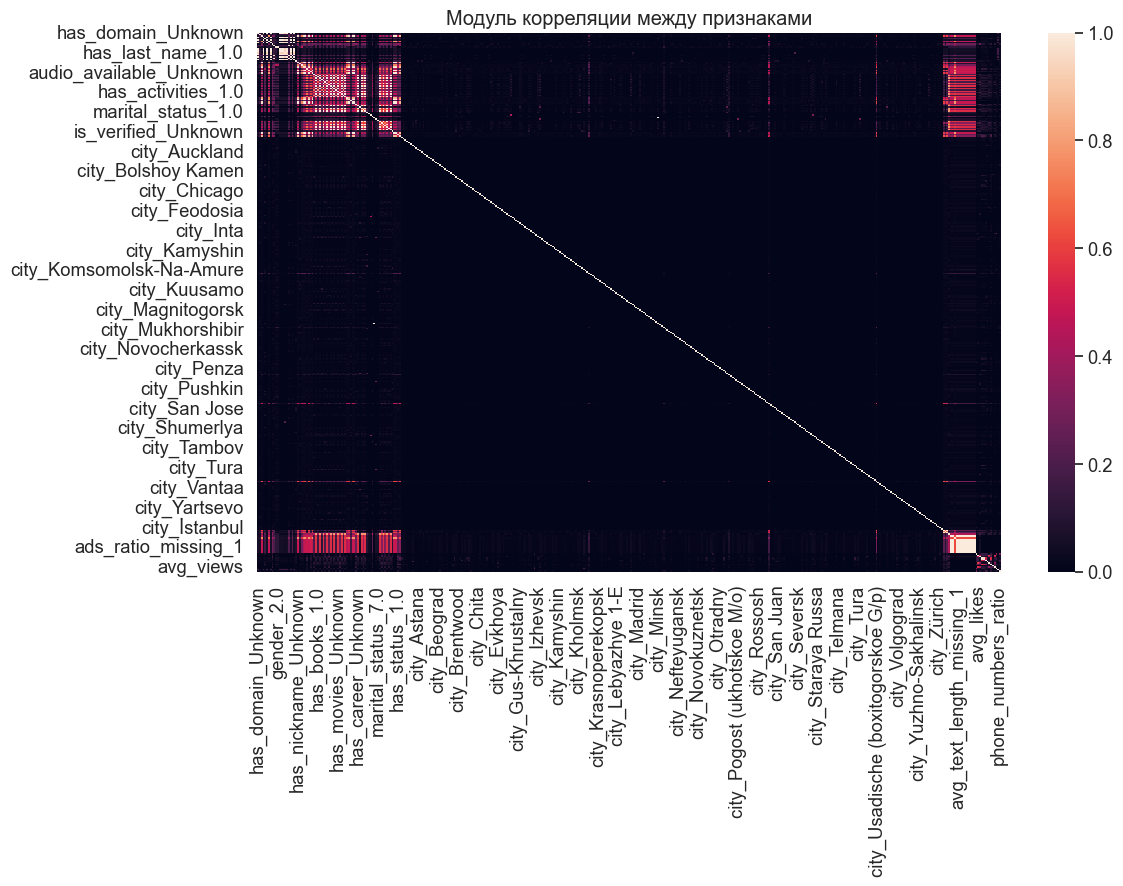

In [20]:
corr_matrix = x_train.corr().abs()
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix).set(title="Модуль корреляции между признаками")

**Ответ:** Попарные корреляции между всеми переменными в наборе данных.

Мы сделали 3 преобразования над данными. Делать это вручную не вполне удобно и правильно. Гораздо лучше использовать пайплайн. Для этого зададим порядок выполнения преобразований так, как этого требует объект типа [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [2]:
real_features = ['posts_count', 'avg_likes', 'subscribers_count', 'avg_keywords', 'avg_text_length', 'links_ratio', 'attachments_ratio', 'avg_comments',
       'reposts_ratio', 'ads_ratio', 'avg_views', 'posting_frequency_days', 'phone_numbers_ratio', 'avg_text_uniqueness']

cat_features = ['has_domain', 'has_birth_date', 'has_photo', 'can_post_on_wall', 'can_send_message', 'has_website', 'gender', 'has_short_name',
                'has_first_name', 'has_last_name', 'access_to_closed_profile', 'is_profile_closed', 'has_nickname', 'has_maiden_name', 
                'has_mobile', 'all_posts_visible', 'audio_available', 'has_interests', 'has_books', 'has_tv', 'has_quotes', 'has_about', 'has_games',
                'has_movies', 'has_activities', 'has_music', 'can_add_as_friend', 'can_invite_to_group', 'is_blacklisted',
                'has_career', 'has_military_service', 'has_hometown', 'marital_status', 'has_universities', 'has_schools', 'has_relatives', 'is_verified',
                'is_confirmed', 'has_status', 'city', 'has_occupation', 'occupation_type_university', 'has_personal_data']

target_feature = ['target']


In [3]:
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preproc_steps = [
    ('num', numeric_transformer, real_features),
    ('cat', categorical_transformer, cat_features)
]

preprocessor = ColumnTransformer(preproc_steps)

preproc = [
    ('preprocessor', preprocessor)
]

Теперь для создания пайплайна достаточно добавить саму модель как четвёртый шаг:


```
model = Pipeline(
    steps=preproc_steps + [
        ('estimator', <Инизиализированная модель>)
    ]
)
```
Такой подход является более надёжным и удобным.

**2.** **Модельки, модельки, модельки...**

**2.1** **Логистическая регрессия без регуляризации**

Обучите классическую лог. регрессию без регуляризации и выведите точность ответа на трейне и тесте.

<details>
  <summary>  Подсказка ✍️</summary>
  
Чему равен аргумент `penalty` по умолчанию?
 </details><br/>

In [ ]:
x_train['subscribers_count'] = x_train['subscribers_count'].replace('Unknown', np.nan)
x_test['subscribers_count'] = x_test['subscribers_count'].replace('Unknown', np.nan)


x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

x_test.shape

c:\Users\User\miniconda3\envs\sad\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [39] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(1175, 411)

In [ ]:
logreg = LogisticRegression(fit_intercept=True, penalty=None, max_iter=1000)

logreg.fit(x_train, y_train)

pred_logreg = logreg.predict(x_test)

print(f'Accuracy for LogisticRegression without penalty: {accuracy_score(y_true=y_test, y_pred=pred_logreg)}')

Accuracy for LogisticRegression without penalty: 0.971063829787234


c:\Users\User\miniconda3\envs\sad\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Вывод:** Логистическая регрессия без регуляризации показала себя неплохо.

**2.2** **Логистическая регрессия с регуляризацией**

За что отвечает гиперпараметр `C` у класса `LogisticRegression`?

**Ответ:** Это коэффициент регуляризации.

Вам необходимо исследовать зависимость от `C` следующих величин:
1. Accuracy на трейне
2. Accuracy на тесте
3. Коэффициенты модели

Чтобы не приходилось постоянно обучать модели при одних и тех же сетках `C`, предлагается написать функцию, которая будет принимать на вход вид штрафа `penalty`, границы диапазона `C`, и саму выборку. На каждой итерации вычисляйте все величины и сохраняйте в виде списков. Для мониторинга времени работы используйте функцию `tqdm`.

In [6]:
from typing import Any, Dict, List, Tuple


def train_alpha_grid(
    log_C_bounds: Tuple[float, float],
    resolution: int,
    data: Dict[str, Any],
    preproc_steps: List[Tuple[str, Any]],
    penalty: str = 'none',
    solver: str = 'newton-cholesky',
    max_iter: int = 100,
) -> Tuple[List[np.ndarray], List[float], List[float]]:
    """Обучает модель LogisticRegression для разных значений параметра регуляризации C,
    сохраняет коэффициенты, вычисляет accuracy на обучающей и тестовой выборках.

    Args:
        log_C_bounds (Tuple[float, float]): кортеж с минимальным и максимальным значением log10(C) для сетки.
        resolution (int): число точек на сетке C.
        data (dict): словарь с обучающей и тестовой выборками (например, {'X_train': ..., 'y_train': ..., 'X_test': ..., 'y_test': ...}).
        preproc_steps (List[Tuple[str, Any]]): список шагов пайплайна.
        penalty (str): тип регуляризации ('l1', 'l2', 'elasticnet', 'none').
        solver (str): метод оптимизации параметров модели (см. аргумент `solver` у класса LogisticRegression).
        max_iter (int): обучение останавливается, если требуемая точность не достигнута за max_iter итераций.

    Returns:
        coefs_list (List[np.ndarray]): список массивов коэффициентов для каждого значения C.
        acc_train_list (List[float]): список accuracy на обучающей выборке для каждого значения C.
        acc_test_list (List[float]): список accuracy на тестовой выборке для каждого значения C.
    """
    
    C_grid = np.logspace(log_C_bounds[0], log_C_bounds[1], num=resolution)
    
    coefs_list = []
    acc_train_list = []
    acc_test_list = []


    for C in C_grid:
        if penalty == 'elasticnet':
            model = Pipeline(
                steps= preproc_steps + [
                    ('estimator', LogisticRegression(fit_intercept=True, penalty=penalty, l1_ratio=0.5, C=C, solver=solver, max_iter=max_iter))
                ]
            )
        else:
            model = Pipeline(
                steps= preproc_steps + [
                    ('estimator', LogisticRegression(fit_intercept=True, penalty=penalty, C=C, solver=solver, max_iter=max_iter))
                ]
            )

        model.fit(data['x_train'], data['y_train'])
        pred_train = model.predict(data['x_train'])
        coefs_list.append(model['estimator'].intercept_.flatten().tolist() + model['estimator'].coef_.flatten().tolist())

        pred_test = model.predict(data['x_test'])

        acc_train_list.append(accuracy_score(y_true=data['y_train'], y_pred=pred_train))
        acc_test_list.append(accuracy_score(y_true=data['y_test'], y_pred=pred_test))

    return coefs_list, acc_train_list, acc_test_list

    

Проведите эксперимент для 3-х разных моделей логистической регрессии с различными типами регуляризации:
1.  $L_1$-регуляризация
2.  $L_2$-регуляризация
3.  Комбинированная регуляризация с параметром `l1_ratio=0.5`.

>*Рекомендации*
>*   Подберите диапазоны значений для гиперпараметра `C`. Не берите слишком узкие, чтобы видеть на графике всю картину. Для слишком широких границ придётся брать больше точек.
>*   Вам не нужна очень частая сетка гиперпараметра `C`. При отладке кода можно вообще использовать сетку из 2-3 значений.
>*   Вы можете столкнуться с различными ошибками и `warning`-ами (например, неверный `solver`, отсутствие сходимости,  и т.д.). Постарайтесь настроить гиперпараметры модели таким образом, чтобы ошибки исчезли, а количество предупреждений было минимальным.

In [7]:
data = pd.read_csv("./datasets/bots_vs_users.csv")
data['city'] = (~data['city'].isin(['Unknown'])).astype(int)
y = data[target_feature]
x = data.drop(target_feature, axis=1)
for f in real_features:    
    x[f] = pd.to_numeric(x[f], errors='coerce')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

splited_data = {
    'x_train': x_train,
    'y_train': y_train.values.ravel(),
    'x_test': x_test,
    'y_test': y_test.values.ravel()
}

l1_coefs_list, l1_acc_train_list, l1_acc_test_list = train_alpha_grid(log_C_bounds = (-2, 3), resolution = 100, data = splited_data,
                                                                      preproc_steps =preproc, penalty = 'l1',
                                                                      solver = 'saga', max_iter = 5000)

l2_coefs_list, l2_acc_train_list, l2_acc_test_list = train_alpha_grid(log_C_bounds = (-2, 3), resolution = 100, data = splited_data,
                                                                      preproc_steps =preproc, penalty = 'l2',
                                                                      solver = 'saga', max_iter = 5000)

el_coefs_list, el_acc_train_list, el_acc_test_list = train_alpha_grid(log_C_bounds = (-2, 3), resolution = 100, data = splited_data,
                                                                      preproc_steps =preproc, penalty = 'elasticnet',
                                                                      solver = 'saga', max_iter = 5000)

In [8]:
l1_coefs_list = np.array(l1_coefs_list)
l2_coefs_list = np.array(l2_coefs_list)
el_coefs_list = np.array(el_coefs_list)

Выберите 8-15 признаков на своё усмотрение либо случайным образом. Нарисуйте треки соответствующих коэффициентов моделей в зависимости от `C`. Свободный коэффициент тоже стоит добавить на графики. Легенду можно сделать общую, если все графики помещаются на экране. Отразите в ней наименования признаков для соответствующих коэффициентов. Сделать красиво могут помочь заметки [отсюда](https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot).

In [ ]:
selected_features = np.random.choice(l1_coefs_list.shape[1], size=10, replace=False)


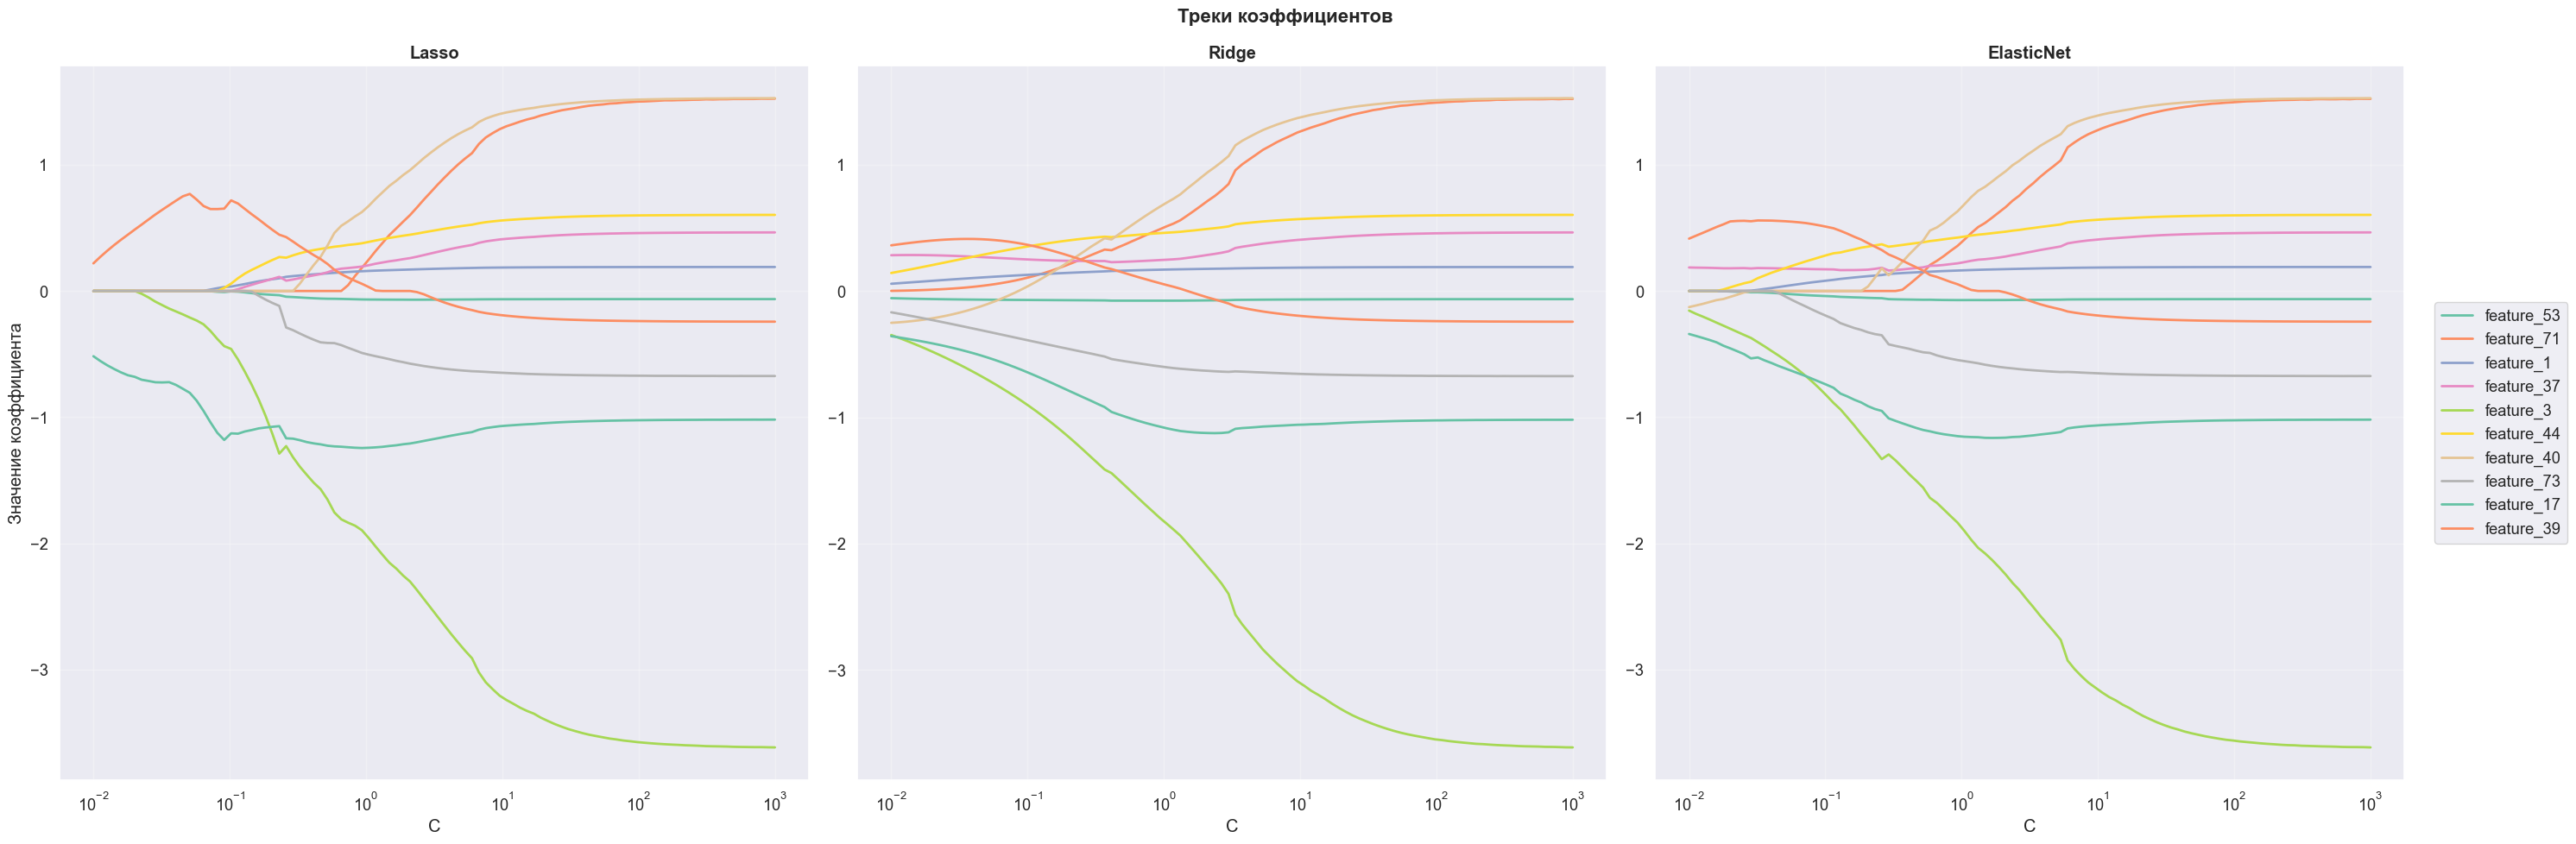

In [ ]:
C_values = np.logspace(-2, 3, num=100)

fig, axes = plt.subplots(1, 3, figsize = (30, 10))
axes.flatten()

for feature in selected_features:
    axes[0].plot(C_values, l1_coefs_list[:, feature], label=f'feature_{feature}', linewidth=2)
axes[0].set_xlabel('C')
axes[0].set_ylabel('Значение коэффициента')
axes[0].set_title('Lasso', fontweight='bold')
axes[0].set_xscale("log")
axes[0].grid(True, alpha=0.3)

for feature in selected_features:
    axes[1].plot(C_values, l2_coefs_list[:, feature], label=f'feature_{feature}', linewidth=2)
axes[1].set_xlabel('C')
axes[1].set_title('Ridge', fontweight='bold')
axes[1].set_xscale("log")
axes[1].grid(True, alpha=0.3)

for feature in selected_features:
    axes[2].plot(C_values, el_coefs_list[:, feature], label=f'feature_{feature}', linewidth=2)
axes[2].set_xlabel('C')
axes[2].set_title('ElasticNet', fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale("log")
axes[2].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

fig.suptitle('Треки коэффициентов', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

**Вывод:**

Нарисуйте зависимости точности предсказания от `C` на обучающей и тестовой выборках. Скомпонуйте всё на 2-3 графиках. Горизонтальными линиями отметьте точность модели без регуляризации на тесте.

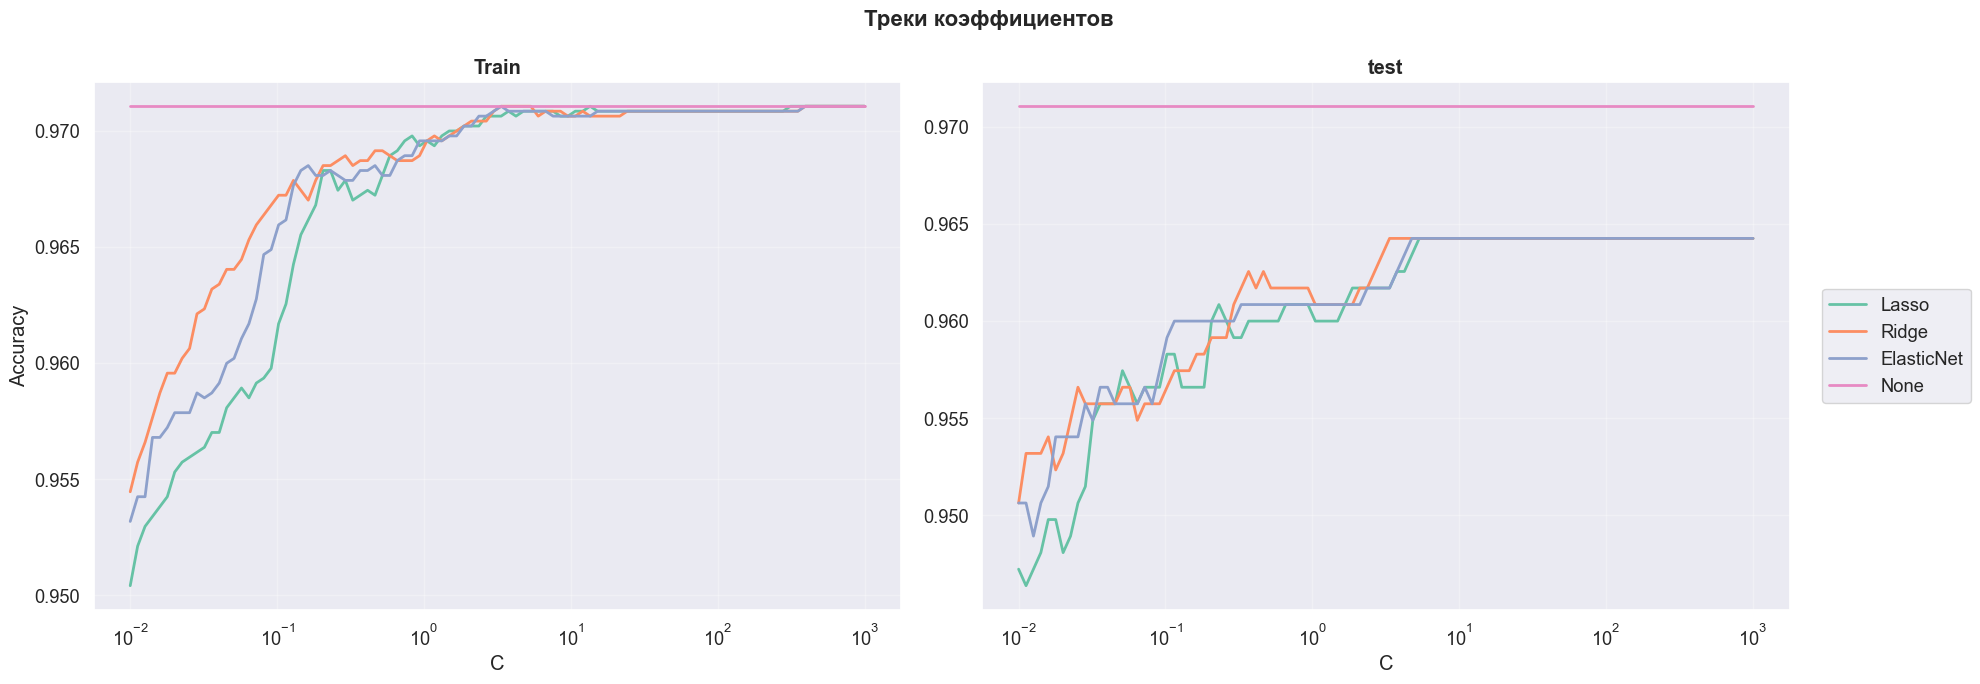

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20, 7))
axes.flatten()

axes[0].plot(C_values, l1_acc_train_list, label='Lasso', linewidth=2)
axes[0].plot(C_values, l2_acc_train_list, label='Ridge', linewidth=2)
axes[0].plot(C_values, el_acc_train_list, label='ElasticNet', linewidth=2)
axes[0].plot(C_values, [0.971063829787234]*len(C_values), label = 'None', linewidth=2)
axes[0].set_xlabel('C')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Train', fontweight='bold')
axes[0].set_xscale("log")
axes[0].grid(True, alpha=0.3)

axes[1].plot(C_values, l1_acc_test_list, label='Lasso', linewidth=2)
axes[1].plot(C_values, l2_acc_test_list, label='Ridge', linewidth=2)
axes[1].plot(C_values, el_acc_test_list, label='ElasticNet', linewidth=2)
axes[1].plot(C_values, [0.971063829787234]*len(C_values), label = 'None', linewidth=2)
axes[1].set_xlabel('C')
axes[1].set_title('test', fontweight='bold')
axes[1].set_xscale("log")
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

fig.suptitle('Треки коэффициентов', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Сделайте вывод. Есть ли польза от регуляризации с точки зрения метрики?

**Вывод:** Да, есть на обучающей выборке.

**3.** **Число обусловленности**

Исследуйте зависимость числа обусловленности от параметра `C` для $L_2$-регуляризации. Постройте соответствующий график.

In [13]:
data = pd.read_csv("./datasets/bots_vs_users.csv")
y = data[target_feature]
x = data.drop(target_feature, axis=1)
for f in real_features:
    x[f] = pd.to_numeric(x[f], errors='coerce')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

C_values = np.logspace(-2, 3, num=100)

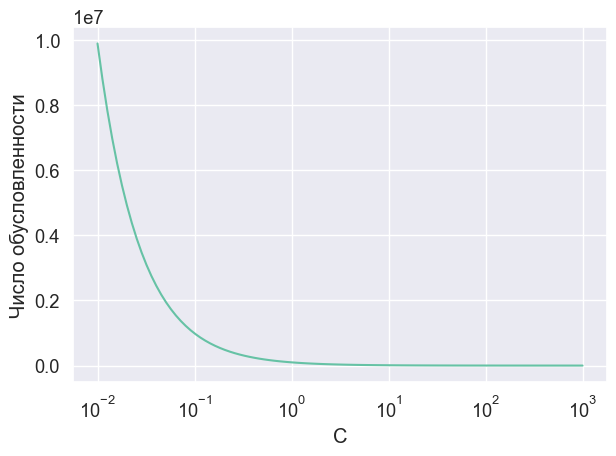

In [14]:
cond_list = []

xa = np.hstack([np.array([1]*x_train.shape[0]).reshape(-1, 1), preprocessor.fit_transform(x_train)])

for i, coef in enumerate(C_values):
    n = xa.shape[1]
    H = xa.T @ xa + C_values[i] * np.eye(n)
    cond_list.append(np.linalg.cond(H))

plt.plot(C_values, cond_list)
plt.xlabel('C')
plt.ylabel('Число обусловленности')
plt.xscale("log")

plt.tight_layout()
plt.show()

Сделайте вывод. О чём свидетельствует полученная зависимость?

**Вывод:** При увеличении коэффициента регуляризации ($C$) число обусловленности уменьшается.

**4.** **Разброс коэффициентов**

Рассмотрите **2 модели:** логистическая регрессия с регуляризацией по-умолчанию и с `penalty=None`. Каждую модель обучите 500 раз при различных разбиениях на обучающую и тестовую выборки. Сохраните коэффициенты для выбранных ранее признаков. Подсчитайте усреднённую метрику качества и визуализируйте распределение каждого коэффициента. Не забудьте про пайплайн.

> Визуализацию предлагается сделать виде сетки графиков. На каждом изобразите **ядерные оценки плотности** для соответствующего коэффициента обеих моделей.
>
> Также напоминаем про удобство использования [логарифмической шкалы](https://matplotlib.org/stable/api/scale_api.html#builtin-scales).

In [ ]:
data = pd.read_csv("./datasets/bots_vs_users.csv")
y = data[target_feature]
x = data.drop(target_feature, axis=1)
for f in real_features:
    x[f] = pd.to_numeric(x[f], errors='coerce')

n_iterations = 500
random_states = np.random.randint(0, 10000, n_iterations)

coefs_l2 = []
coefs_none = []
metrics_l2 = []
metrics_none = []

for i, random_state in enumerate(random_states):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)
    y_train, y_test = y_train.values.ravel(), y_test.values.ravel()


    model_l2 = Pipeline(
                steps= preproc + [
                    ('estimator', LogisticRegression(fit_intercept=True, penalty='l2', C=1, solver='saga', max_iter=5000))
                ]
            )

    model_none = Pipeline(
                steps= preproc + [
                    ('estimator', LogisticRegression(fit_intercept=True, penalty=None, solver='saga', max_iter=5000))
                ]
            )

    model_l2.fit(x_train, y_train)
    model_none.fit(x_train, y_train)

    y_pred_l2 = model_l2.predict(x_test)
    y_pred_none = model_none.predict(x_test)

    acc_l2 = accuracy_score(y_test, y_pred_l2)
    acc_none = accuracy_score(y_test, y_pred_none)

    metrics_l2.append(acc_l2)
    metrics_none.append(acc_none)

    coef_l2 = []
    coef_none = []
    coef_l2.append(model_l2['estimator'].coef_[:, 0])
    coef_none.append(model_none['estimator'].coef_[:, 0])
    for i, feature in enumerate(selected_features):
        coef_l2.append(model_l2['estimator'].coef_[:, selected_features[i]])
        coef_none.append(model_none['estimator'].coef_[:, selected_features[i]])
    coefs_l2.append(coef_l2)
    coefs_none.append(coef_none)

In [7]:
coefs_l2 = np.array(coefs_l2)
coefs_none = np.array(coefs_none)
metrics_l2 = np.array(metrics_l2)
metrics_none = np.array(metrics_none)

print(f'Mean value of accucary for LogReg with L2-penalty: {metrics_l2.mean()}')
print(f'Mean value of accucary for LogReg without penalty: {metrics_none.mean()}')

Mean value of accucary for LogReg with L2-penalty: 0.9678297872340427
Mean value of accucary for LogReg without penalty: 0.9681702127659573


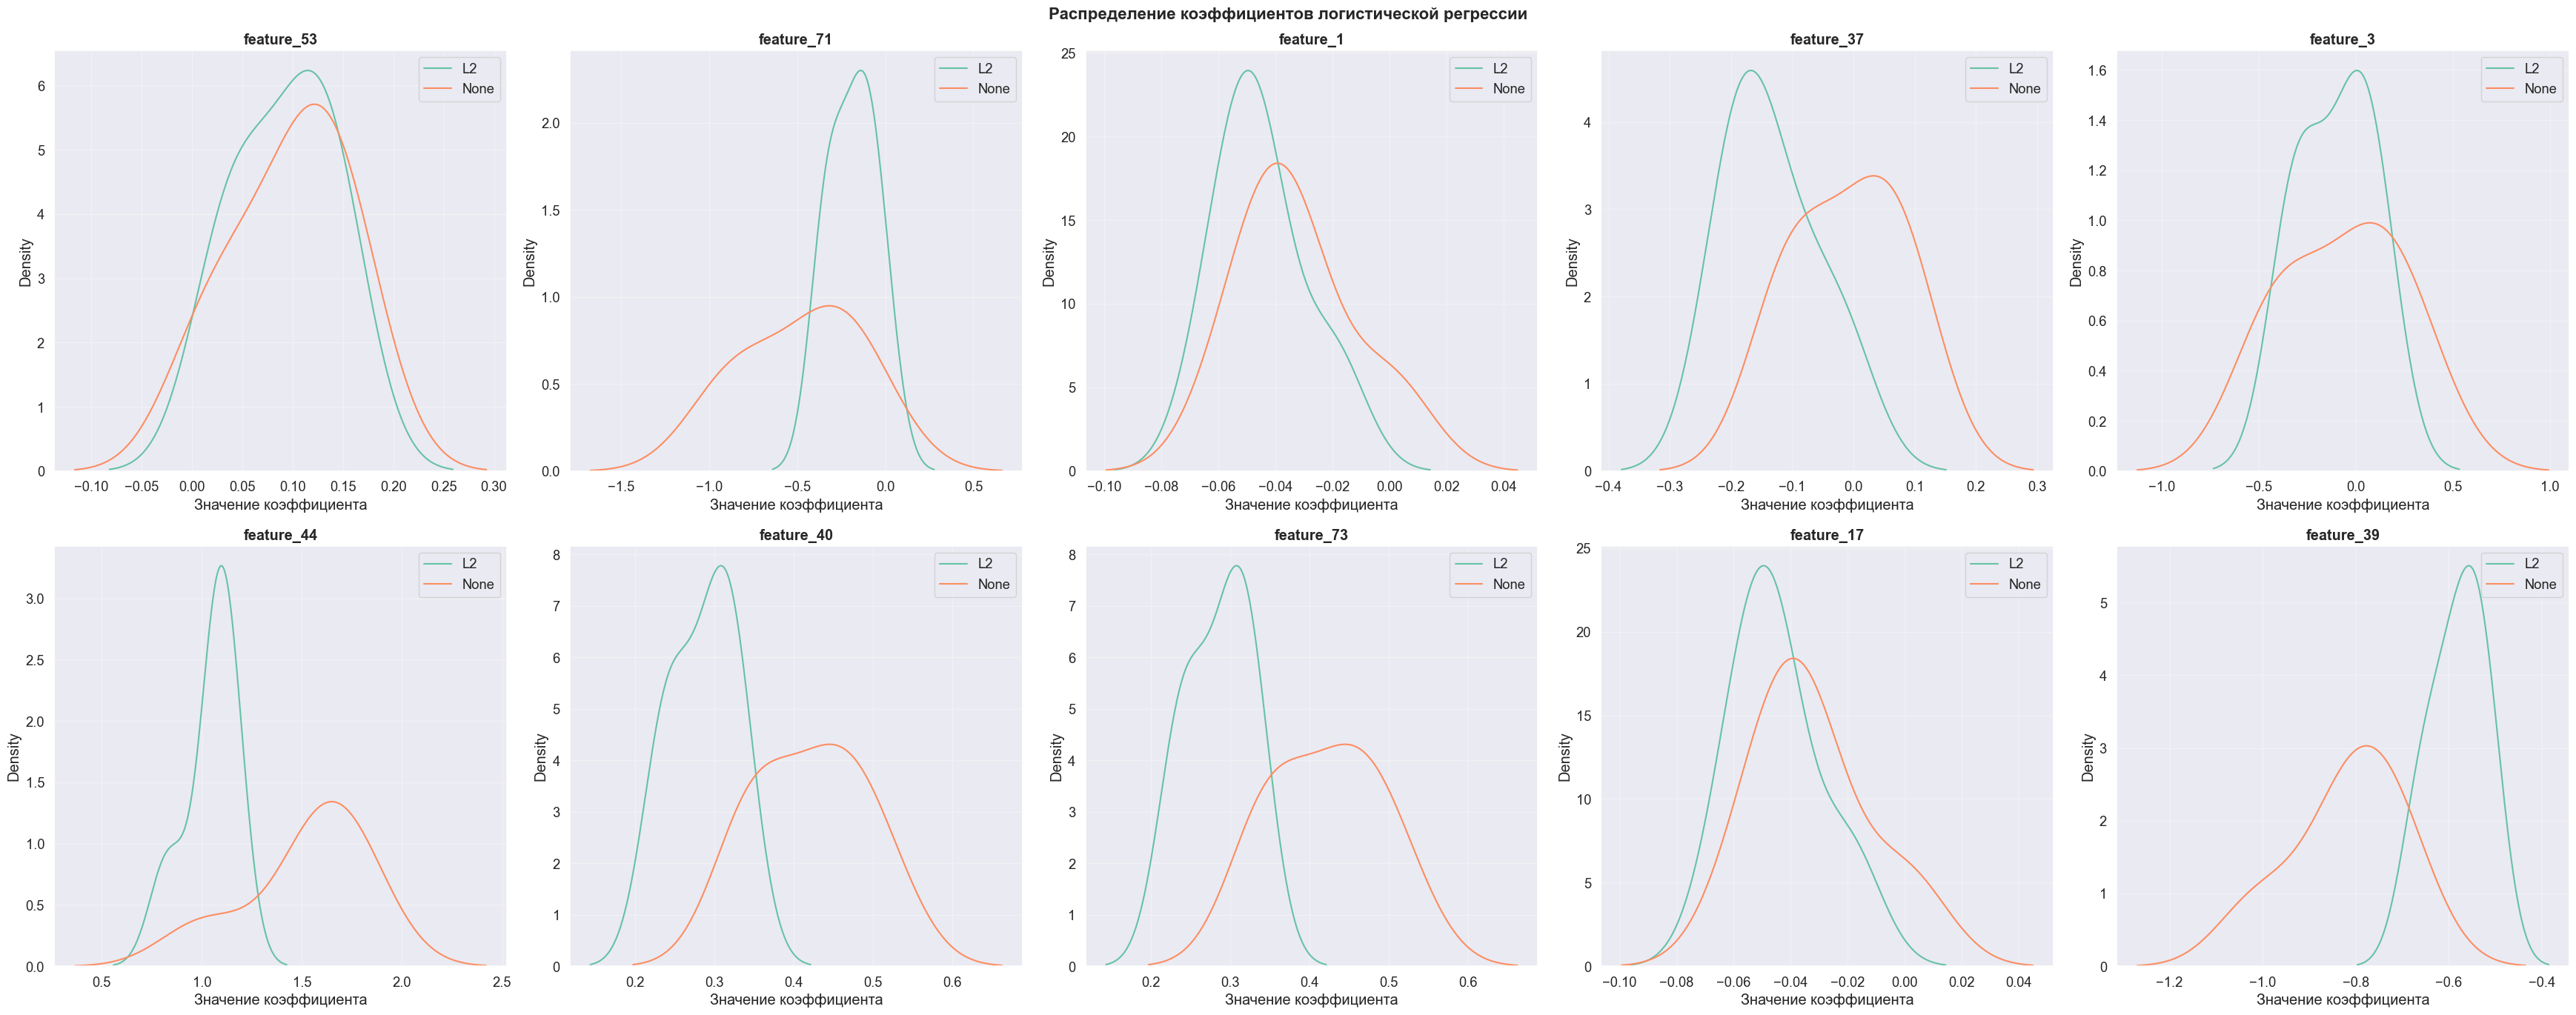

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(7*5, 7*2))

fig.suptitle('Распределение коэффициентов логистической регрессии', fontsize=16,  fontweight='bold')

for i, ax in enumerate(axes.flat):
    sns.kdeplot(coefs_l2[:, selected_features[i].ravel(), ax = ax, label = f'L2')
    sns.kdeplot(coefs_none[:, selected_features[i]].ravel(), ax = ax, label = f'None')

    ax.set_xlabel('Значение коэффициента')
    ax.set_title(f"feature_{selected_features[i]}", fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

Какой модели вы больше доверитесь при интерпретации коэффициентов? Почему разработчики sklearn по-умолчанию добавили в логистическую регрессию небольшую $L_2$-регуляризацию? В чём заключается её польза? Порассуждайте над этими вопросами и попробуйте написать интерпретацию выведенных коэффициентов.

**Вывод** Логистическая регрессия без регуляризации, т.к. для этой модели коэффициенты можно интерпретировать при подсчёте шансов. Для устойчивости обращения матриц и числовой стабильности.

---
© 2025 команда <a href="https://thetahat.ru/">ThetaHat</a> для курса ML-1 ШАД